# **Part 1:** Data Preparation (Ching-min & Dandan)##

Chosen Superclass: Small mammals and Medium-sized mammals.

In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,734 kB]
Get:1

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Import the necessary packages
%%time
import findspark
findspark.init(os.environ["SPARK_HOME"])# SPARK_HOME
from pyspark.sql.types import Row
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
import numpy as np
import json


# Increase the memory limit/maximum memory configuration
#spark = SparkSession.builder.master("local[*]").getOrCreate()
Memory_limit = "12g"
spark = SparkSession.builder.appName("Foo").config("spark.executor.memory", Memory_limit).config("spark.driver.memory", Memory_limit).getOrCreate()

CPU times: user 146 ms, sys: 38.4 ms, total: 184 ms
Wall time: 4.44 s


## **Download data**

In [0]:
#2. Get the file
# Make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
%%time
downloaded1 = drive.CreateFile({'id':'1YoyOoPty-a3i8oMStdheWrDTCKrcONG3'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('train')
downloaded2 = drive.CreateFile({'id':'1Qe_Z5HGgdF2_c8XoypiCIGutK6wAvb8e'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test')
downloaded3 = drive.CreateFile({'id':'1eqHqAAOx0OuMhnpgTkBlvUPx9eGH0snZ'}) # replace the id with id of file you want to access
downloaded3.GetContentFile('meta')

CPU times: user 367 ms, sys: 563 ms, total: 930 ms
Wall time: 3.71 s


In [0]:
# Unpickle the file
%%time
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

# Fetch the Train data
datatrain = unpickle('train')

# Fetch the test data
datatest = unpickle('test')

# Fetch the metadata
datameta = unpickle("meta")

# Convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8')for x in datameta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in datameta.get(b'coarse_label_names')]
print(coarse_labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [0]:
# Generate the train data RDD
%%time
cifar_train_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatrain.get(b'filenames')],\
    datatrain.get(b'fine_labels'), datatrain.get(b'coarse_labels'), \
    datatrain.get(b'data'))))
print (cifar_train_RDD.count())
cifar_train_RDD.map(lambda x: x[3]).take(1)

50000
CPU times: user 448 ms, sys: 190 ms, total: 639 ms
Wall time: 3.41 s


In [0]:
# Generate the test data RDD
%%time
cifar_test_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatest.get(b'filenames')],\
    datatest.get(b'fine_labels'), datatest.get(b'coarse_labels'), \
    datatest.get(b'data'))))
print (cifar_test_RDD.count())

10000
CPU times: user 96.9 ms, sys: 35.5 ms, total: 132 ms
Wall time: 578 ms


## **Combine the training RDD and test RDD into one RDD**

In [0]:
# Combine the train RDD and test RDD into one RDD, may take a long while to run
%%time
combine_rdd = cifar_train_RDD.union(cifar_test_RDD)
print (combine_rdd.count())

60000
CPU times: user 7.4 ms, sys: 2.21 ms, total: 9.61 ms
Wall time: 992 ms


Seed is used to save the state of the random function in subsequent executions.

In [0]:
# Take a sample from the data
%%time
print (combine_rdd.takeSample(withReplacement=False, num=5, seed=123))

[('power_mower_s_000260.png', 41, 19, array([255, 242, 202, ..., 255, 252, 252], dtype=uint8)), ('bicycle_s_002728.png', 8, 18, array([0, 0, 0, ..., 4, 4, 6], dtype=uint8)), ('sunflower_s_000513.png', 82, 2, array([36, 43, 47, ..., 84, 90, 70], dtype=uint8)), ('poppy_s_001505.png', 62, 2, array([4, 4, 4, ..., 7, 7, 8], dtype=uint8)), ('rosebush_s_001692.png', 70, 2, array([23, 24, 26, ..., 66, 68, 68], dtype=uint8))]
CPU times: user 13.9 ms, sys: 4.46 ms, total: 18.4 ms
Wall time: 1.59 s


Here, we convert the RDD into Dataframe and normalize the image data by dividing it with the largest pixel value, which is 255.

In [0]:
# Convert the combined RDD into spark dataframe and normalize
%%time
combine_df = spark.createDataFrame(combine_rdd.map(lambda x: Row(filenames=x[0], fine_labels=int(x[1]), coarse_labels=int(x[2]), data=DenseVector(x[3])/255.0)) )
print (combine_df.count())

60000
CPU times: user 28.9 ms, sys: 5.94 ms, total: 34.8 ms
Wall time: 1min 52s


In [0]:
# Print the first 10 rows
%%time
combine_df.show()

+-------------+--------------------+--------------------+-----------+
|coarse_labels|                data|           filenames|fine_labels|
+-------------+--------------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|bos_taurus_s_0005...|         19|
|           15|[1.0,0.9921568627...|stegosaurus_s_000...|         29|
|            4|[0.98039215686274...|mcintosh_s_000643...|          0|
|           14|[0.48627450980392...|altar_boy_s_00143...|         11|
|            1|[0.16862745098039...|cichlid_s_000031.png|          1|
|            5|[0.74509803921568...|  phone_s_002161.png|         86|
|           18|[0.19607843137254...|car_train_s_00004...|         90|
|            3|[0.69803921568627...| beaker_s_000604.png|         28|
|           10|[0.47843137254901...|    fog_s_000397.png|         23|
|           11|[1.0,1.0,1.0,1.0,...|rogue_elephant_s_...|         31|
|            5|[0.32549019607843...|computer_keyboard...|         39|
|           17|[0.99

## **Filter out the assigned superclasses**

In [0]:
# Get the index of ten classes of animals
%%time
#medium_sized_mammals_index = [ fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
#small_mammals_index = [ fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_mammals_index = [ coarse_labels.index(x) for x in ['medium_mammals'] ]
small_mammals_index = [ coarse_labels.index(x) for x in ['small_mammals'] ]

target_index = medium_sized_mammals_index + small_mammals_index
print (medium_sized_mammals_index, small_mammals_index)
print(target_index)

[12] [16]
[12, 16]
CPU times: user 1.22 ms, sys: 0 ns, total: 1.22 ms
Wall time: 2.32 ms


In [0]:
# Verify the label number
%%time
for ind in target_index:
  print ("Index", ind, "is for coarse label:", coarse_labels[ind])

Index 12 is for coarse label: medium_mammals
Index 16 is for coarse label: small_mammals
CPU times: user 332 µs, sys: 1.68 ms, total: 2.01 ms
Wall time: 4.51 ms


In [0]:
# Filter out the assigned ten fine classes, reorder columns and check the count
%%time
from pyspark.sql.functions import col

target_df = combine_df.filter(col('coarse_labels').isin(target_index))                 # Can do combine_df.filter((combine_df['coarse_labels']==12) | (combine_df['coarse_labels']==16))
target_df = target_df.select("data","coarse_labels","fine_labels","filenames")

print ("Count:", target_df.count())

Count: 6000
CPU times: user 17.4 ms, sys: 5.47 ms, total: 22.9 ms
Wall time: 1min 50s


In [0]:
# Import packages
%%time
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

CPU times: user 2.59 ms, sys: 303 µs, total: 2.9 ms
Wall time: 5.31 ms


In [0]:
# Add two columns fine label as fine and coarse label as coarse
%%time
target_name_df = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels']))

CPU times: user 8.37 ms, sys: 4.1 ms, total: 12.5 ms
Wall time: 39.1 ms


In [0]:
# Display the statistical features of the data
%%time
target_name_df.describe().show()

+-------+-----------------+------------------+--------------------+--------------+--------+
|summary|    coarse_labels|       fine_labels|           filenames|        coarse|    fine|
+-------+-----------------+------------------+--------------------+--------------+--------+
|  count|             6000|              6000|                6000|          6000|    6000|
|   mean|             14.0|              60.7|                null|          null|    null|
| stddev|2.000166687502895|15.014911741191348|                null|          null|    null|
|    min|               12|                34|american_water_sh...|medium_mammals|     fox|
|    max|               16|                80|water_shrew_s_000...| small_mammals|squirrel|
+-------+-----------------+------------------+--------------------+--------------+--------+

CPU times: user 13.9 ms, sys: 5.77 ms, total: 19.7 ms
Wall time: 1min 51s


In [0]:
# Print the first 3 rows
%%time
target_name_df.show(3)

+--------------------+-------------+-----------+--------------------+--------------+--------+
|                data|coarse_labels|fine_labels|           filenames|        coarse|    fine|
+--------------------+-------------+-----------+--------------------+--------------+--------+
|[0.27843137254901...|           16|         80|squirrel_s_002467...| small_mammals|squirrel|
|[0.61176470588235...|           16|         74|  shrew_s_002233.png| small_mammals|   shrew|
|[0.96078431372549...|           12|         64|opossum_s_001237.png|medium_mammals|  possum|
+--------------------+-------------+-----------+--------------------+--------------+--------+
only showing top 3 rows

CPU times: user 5.57 ms, sys: 2.21 ms, total: 7.79 ms
Wall time: 45.6 s


# **Visualize and validate the data**

In [0]:
# Generate sample data randomly
%%time
fractions = dict()
for fine in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']:
  fractions[fine] = 0.02                              

sample_df = target_name_df.sampleBy('fine', fractions)
print(sample_df.count())

126
CPU times: user 20.8 ms, sys: 2.94 ms, total: 23.8 ms
Wall time: 2min 16s


In [0]:
# Generate the samples list
%%time
samples = sample_df.select('coarse', 'fine', 'data').orderBy('coarse', 'fine').rdd.collect()

CPU times: user 75 ms, sys: 18.5 ms, total: 93.5 ms
Wall time: 3min 37s


CPU times: user 557 ms, sys: 0 ns, total: 557 ms
Wall time: 560 ms


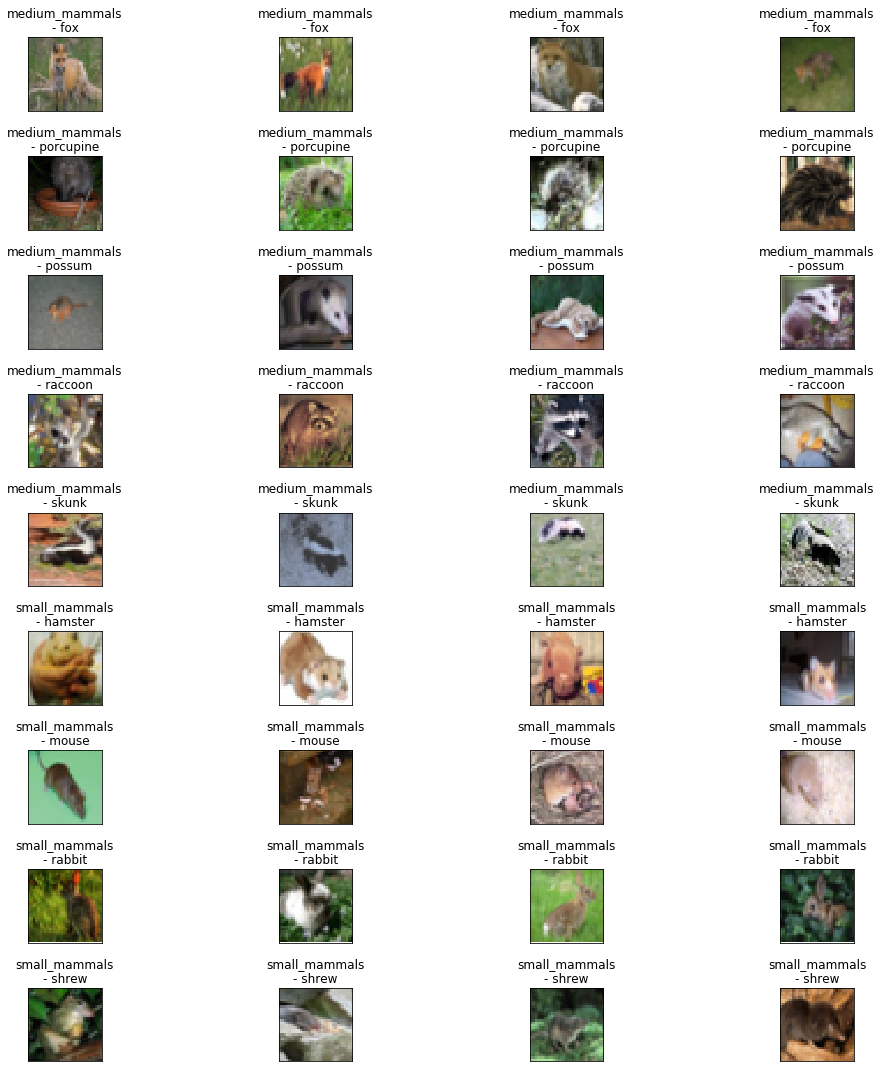

In [0]:
# Visualize the data
%%time
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0
counts = dict.fromkeys(['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'], 0) 

fig = plt.figure(figsize=(15, 15))
index = 1
for sample in samples:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(9, 4, index, xticks=[], yticks=[])
  plt.imshow(img)
  plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  index += 1
  if index > 36:
    break

fig.set_tight_layout(True)

##  **Pre-requisite:** Process and verify training and testing set (Rajasree & Megha)## 

This step is important as Pyspark's ML algorithms tend to have a specified format for input features and labels.

In [0]:
# Change the coarse label into a binary label
%%time
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='binary_index')
target_name_df = stringindexer.fit(target_name_df).transform(target_name_df)

# Select the distinct binary indices
print ("Distinct binary indices:", target_name_df.select('binary_index').distinct().collect() )

Distinct binary indeices: [Row(binary_index=0.0), Row(binary_index=1.0)]
CPU times: user 61.2 ms, sys: 17.2 ms, total: 78.4 ms
Wall time: 3min 41s


In [0]:
# Rename data as features and re-order columns 
%%time
target_name_df = target_name_df.withColumnRenamed("data","features").select("features","binary_index", "coarse_labels","coarse","fine_labels","fine")

CPU times: user 4.58 ms, sys: 1.39 ms, total: 5.97 ms
Wall time: 40.9 ms


In [0]:
# Verify the data type
%%time
target_name_df.dtypes

CPU times: user 360 µs, sys: 1.86 ms, total: 2.22 ms
Wall time: 18.1 ms


[('features', 'vector'),
 ('binary_index', 'double'),
 ('coarse_labels', 'bigint'),
 ('coarse', 'string'),
 ('fine_labels', 'bigint'),
 ('fine', 'string')]

In [0]:
# Check for null values in each column
%%time
for c in target_name_df.columns: 
  print ("Column",c, "- no.of null values:", target_name_df.where(col(c).isNull()).count()) 

Column features - no.of null values: 0
Column binary_index - no.of null values: 0
Column coarse_labels - no.of null values: 0
Column coarse - no.of null values: 0
Column fine_labels - no.of null values: 0
Column fine - no.of null values: 0
CPU times: user 75 ms, sys: 20.3 ms, total: 95.3 ms
Wall time: 9min 5s


Here, we randomly select 80% of data as training data and remaining 20% data as testing data. Seed is used to save the state of the random function in subsequent executions.

In [0]:
# Split randomly into training set and testing set
%%time
train_df, test_df = target_name_df.randomSplit([0.80,0.20], seed=1369)

CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 27.6 ms


In [0]:
# Count the number of entries in training and testing data
%%time
print ("Training set count:", train_df.count(), \
       "\nTesting set count:", test_df.count())

Training set count: 4857 
Testing set count: 1143
CPU times: user 26.3 ms, sys: 6.57 ms, total: 32.9 ms
Wall time: 3min 38s


In [0]:
# Check the distinct labels
%%time
print("Distinct labels in the training set -", train_df.select('coarse_labels','binary_index','coarse').distinct().collect(),\
      "\nDistinct labels in the testing set -", train_df.select('coarse_labels','binary_index','coarse').distinct().collect())

Distinct labels in the training set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals')] 
Distinct labels in the testing set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals')]
CPU times: user 72.5 ms, sys: 21.1 ms, total: 93.6 ms
Wall time: 3min 38s


## Study the training data

In [0]:
# Verify the training set file type
%%time
print ("Training data - Type", type(train_df))

Training data - Type <class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 0 ns, sys: 999 µs, total: 999 µs
Wall time: 1.15 ms


In [0]:
# Verify the Schema
%%time
train_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 1.48 ms, sys: 0 ns, total: 1.48 ms
Wall time: 4.89 ms


In [0]:
# Display the statistical features 
%%time
train_df.describe().show()

+-------+------------------+------------------+--------------+-----------------+--------+
|summary|      binary_index|     coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+------------------+--------------+-----------------+--------+
|  count|              4857|              4857|          4857|             4857|    4857|
|   mean|0.4968087296685197|14.012765081325922|          null| 60.6438130533251|    null|
| stddev|0.5000412946929902|2.0001651787719608|          null|15.04927242806568|    null|
|    min|               0.0|                12|medium_mammals|               34|     fox|
|    max|               1.0|                16| small_mammals|               80|squirrel|
+-------+------------------+------------------+--------------+-----------------+--------+

CPU times: user 14.8 ms, sys: 3 ms, total: 17.8 ms
Wall time: 1min 48s


In [0]:
## Print the first 5 rows
%%time
train_df.show(5)

+--------------------+------------+-------------+--------------+-----------+-------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|   fine|
+--------------------+------------+-------------+--------------+-----------+-------+
|[0.0,0.0,0.0,0.0,...|         1.0|           12|medium_mammals|         34|    fox|
|[0.0,0.0,0.0,0.0,...|         1.0|           12|medium_mammals|         75|  skunk|
|[0.0,0.0078431372...|         0.0|           16| small_mammals|         36|hamster|
|[0.0,0.0470588235...|         0.0|           16| small_mammals|         36|hamster|
|[0.00392156862745...|         0.0|           16| small_mammals|         36|hamster|
+--------------------+------------+-------------+--------------+-----------+-------+
only showing top 5 rows

CPU times: user 5.3 ms, sys: 2.59 ms, total: 7.9 ms
Wall time: 44.3 s


## Study the testing data

In [0]:
# Verify the testing set file type
%%time
print ("Testing data - Type ", type(test_df))

Testing data - Type  <class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 738 µs, sys: 955 µs, total: 1.69 ms
Wall time: 5.14 ms


In [0]:
# Verify the schema
%%time
test_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 618 µs, sys: 151 µs, total: 769 µs
Wall time: 1.37 ms


In [0]:
# Display the statistical features 
%%time
test_df.describe().show()

+-------+------------------+-----------------+--------------+-----------------+--------+
|summary|      binary_index|    coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+-----------------+--------------+-----------------+--------+
|  count|              1143|             1143|          1143|             1143|    1143|
|   mean|0.5135608048993876|13.94575678040245|          null|60.93875765529309|    null|
| stddev|0.5000348565118707|2.000139426047483|          null|14.87218495448389|    null|
|    min|               0.0|               12|medium_mammals|               34|     fox|
|    max|               1.0|               16| small_mammals|               80|squirrel|
+-------+------------------+-----------------+--------------+-----------------+--------+

CPU times: user 10.9 ms, sys: 7.31 ms, total: 18.2 ms
Wall time: 1min 47s


In [0]:
## Print the first 5 rows
%%time
test_df.show(5)

+--------------------+------------+-------------+--------------+-----------+---------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|     fine|
+--------------------+------------+-------------+--------------+-----------+---------+
|[0.0,0.0,0.0,0.0,...|         0.0|           16| small_mammals|         50|    mouse|
|[0.0,0.0,0.0,0.00...|         1.0|           12|medium_mammals|         63|porcupine|
|[0.0,0.0,0.003921...|         0.0|           16| small_mammals|         74|    shrew|
|[0.00392156862745...|         0.0|           16| small_mammals|         36|  hamster|
|[0.00784313725490...|         1.0|           12|medium_mammals|         63|porcupine|
+--------------------+------------+-------------+--------------+-----------+---------+
only showing top 5 rows

CPU times: user 7.21 ms, sys: 1.01 ms, total: 8.22 ms
Wall time: 44.3 s


### Define a function for imaging predictions 

We call the below function to verify our predictions. Wrong predictions are labeled in red. 

Further, we tried to incorporate the code for confusion matrix and classification report in functions, but decided to forgo the same due to longer execution time.

In [0]:
# Function to print out randomly chosen images and their labels from predictions
%%time
def cifar_grid(predictions):  
  samples = predictions.select(['coarse', 'prediction','fine','binary_index','features']).orderBy(rand()).limit(36).rdd.collect()
  
  fig = plt.figure(figsize=(15, 20))
  plt.subplots_adjust(hspace=2, wspace=2)
  index = 0
  n_row = 9
  n_col = 4
  for k in range(n_col):
    for j in range(n_row):
      #for sample in samples:
      i_inds = (j*n_col)+k
      label = ('small mammals' if samples[i_inds].binary_index == 0.0 else 'medium mammals')
      pred = ('small mammals' if samples[i_inds].prediction == 0.0 else 'medium mammals')
      ax= fig.add_subplot(9, 4, index+1, xticks=[], yticks=[])
      #ax = fig.add_subplot(n_row, n_col, i_inds+1)
      img = samples[i_inds].features.reshape(3,32,32).transpose([1, 2, 0])  
      ax = plt.imshow(img, interpolation='nearest')
      if label == pred:
        plt.title("Predicted: {}\n Actual: {}".format(pred,label))
      else:
        plt.title("Predicted: {}\n Actual: {}".format(pred,label), color = "red")
      index += 1     
  fig.set_tight_layout(True)

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 7.39 µs


# **Part 2:** Prediction (Megha & Rajasree)##


## **Model 1** - Logistic Regression

In [0]:
## Import the necesary packages
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

CPU times: user 949 µs, sys: 2.04 ms, total: 2.98 ms
Wall time: 3.05 ms


In [0]:
# Create a Logistic Regression model, fit, predict and print relevant columns from the first 10 rows
%%time
lr = LogisticRegression(labelCol="binary_index", featuresCol="features",maxIter=10)
model=lr.fit(train_df)
predict_lr=model.transform(test_df)
predict_lr.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.47472145551301...|
|medium_mammals|         1.0|       1.0|[0.43350257031928...|
| small_mammals|         0.0|       0.0|[0.66759395480564...|
| small_mammals|         0.0|       0.0|[0.65729166310509...|
|medium_mammals|         1.0|       1.0|[0.43337212473262...|
|medium_mammals|         1.0|       0.0|[0.67365162847310...|
|medium_mammals|         1.0|       1.0|[0.40707934151075...|
|medium_mammals|         1.0|       0.0|[0.50087052162286...|
|medium_mammals|         1.0|       1.0|[0.14650473985964...|
|medium_mammals|         1.0|       1.0|[0.43103612241028...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 52.6 ms, sys: 11.8 ms, total: 64.5 ms
Wall time: 2min 40s


In [0]:
# Print the prediction score / accuracy
%%time
eval=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")
accuracy = (eval.evaluate(predict_lr))*100
print("Model Accuracy: %.3f%%" % accuracy)

Model Accuracy: 62.173%
CPU times: user 16.6 ms, sys: 4.09 ms, total: 20.7 ms
Wall time: 1min 47s


In [0]:
# Check the output file type
%%time
type(predict_lr)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 10.5 µs


pyspark.sql.dataframe.DataFrame

CPU times: user 738 ms, sys: 18.6 ms, total: 756 ms
Wall time: 1min 49s


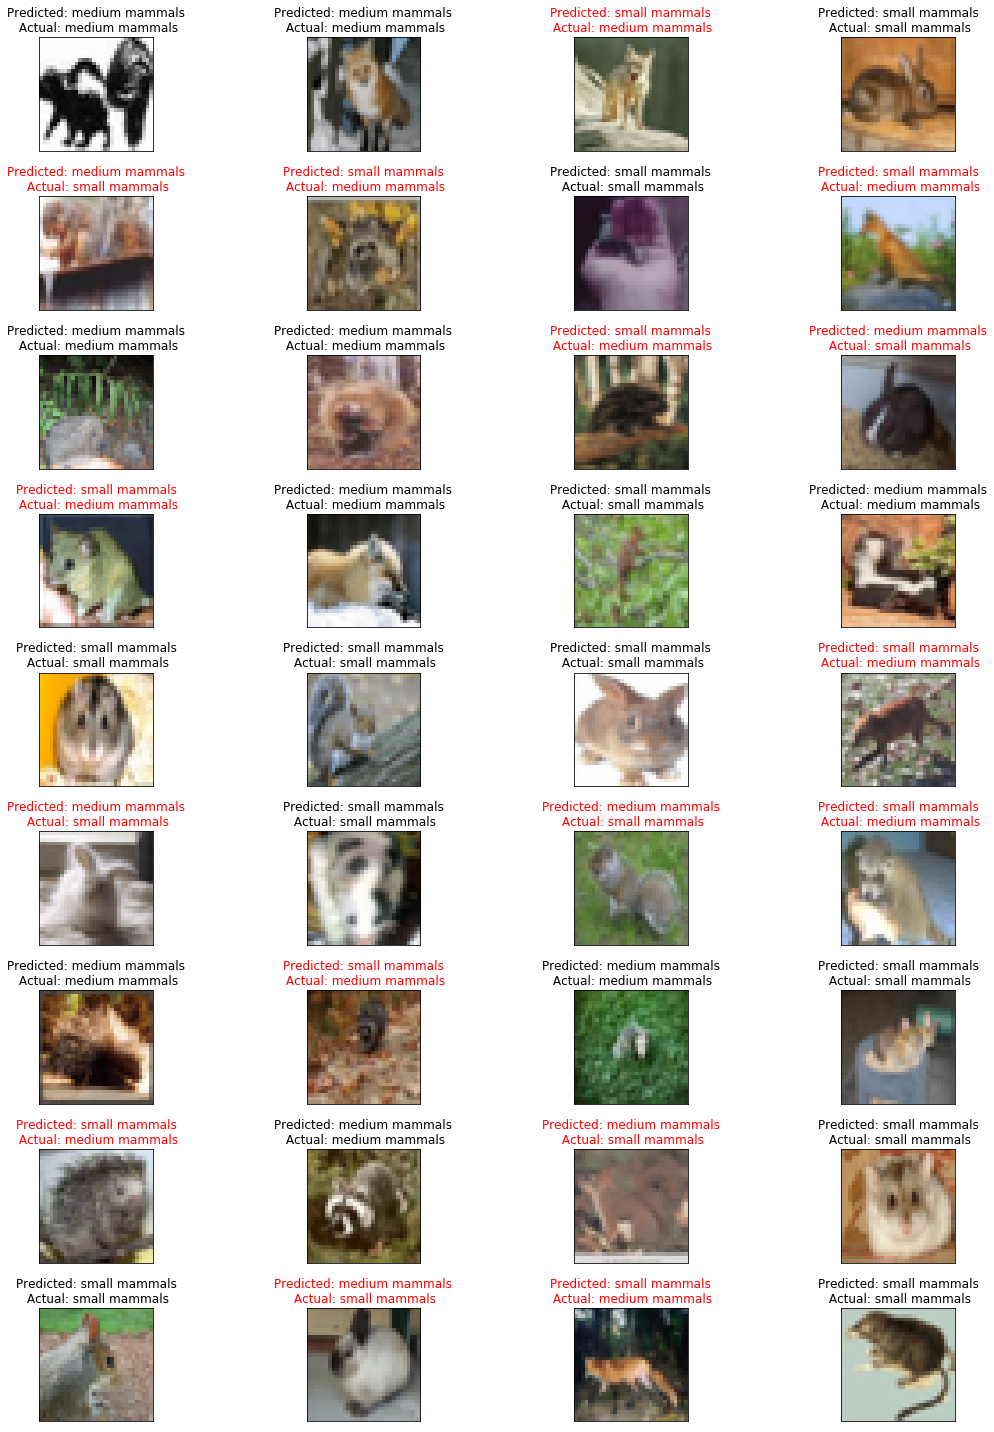

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_lr)

####**Confusion matrix and classification report for Logistic Regression**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat1 = predict_lr.select("binary_index","prediction")
print (conf_mat1.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 145, Row(binary_index=1.0, prediction=1.0): 296, Row(binary_index=0.0, prediction=0.0): 411, Row(binary_index=1.0, prediction=0.0): 291})
CPU times: user 42.1 ms, sys: 6.77 ms, total: 48.9 ms
Wall time: 3min 38s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD_1 = predict_lr.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics1 = MulticlassMetrics(predictionRDD_1)


cm1 = metrics1.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm1[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         411         145
real  1         291         296
CPU times: user 42.4 ms, sys: 7.34 ms, total: 49.8 ms
Wall time: 3min 39s


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr1(label_in):
  precision = metrics1.precision(label=label_in)
  recall = metrics1.recall(label=label_in)
  F1_Measure = metrics1.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr1(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.59          0.74         0.65          556
       1.0         0.67          0.50         0.58          587
CPU times: user 58.8 ms, sys: 12.5 ms, total: 71.3 ms
Wall time: 7min 15s


##**Model 2** - Naive Bayes Classifier

In [0]:
# Import the necessary package(s)
%%time
from pyspark.ml.classification import NaiveBayes

CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 20.3 µs


In [0]:
# Create a Naive bayes classifier-based model, fit, predict and print relevant columns from the first 10 rows
%%time
naive_bayes = NaiveBayes(featuresCol="features", labelCol="binary_index",smoothing=1.0, modelType="multinomial")
naive_bayes = naive_bayes.fit(train_df)
predict_nb = naive_bayes.transform(test_df)
predict_nb.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.04699485125869...|
|medium_mammals|         1.0|       1.0|[0.37349437754014...|
| small_mammals|         0.0|       1.0|[0.49742404147437...|
| small_mammals|         0.0|       0.0|[0.60447148053640...|
|medium_mammals|         1.0|       1.0|[0.08935989872676...|
|medium_mammals|         1.0|       0.0|[0.99281403497744...|
|medium_mammals|         1.0|       1.0|[0.00413106018955...|
|medium_mammals|         1.0|       0.0|[0.98257673622296...|
|medium_mammals|         1.0|       1.0|[1.38216751282667...|
|medium_mammals|         1.0|       0.0|[0.65504292132605...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 36.4 ms, sys: 13.5 ms, total: 49.9 ms
Wall time: 3min 19s


In [0]:
# Print the prediction score / accuracy
%%time
accuracy2 = (eval.evaluate(predict_nb))*100
print("Model Accuracy: %.3f%%" % accuracy2)

Model Accuracy: 60.152%
CPU times: user 13.5 ms, sys: 5.09 ms, total: 18.6 ms
Wall time: 1min 47s


CPU times: user 419 ms, sys: 11.7 ms, total: 431 ms
Wall time: 1min 48s


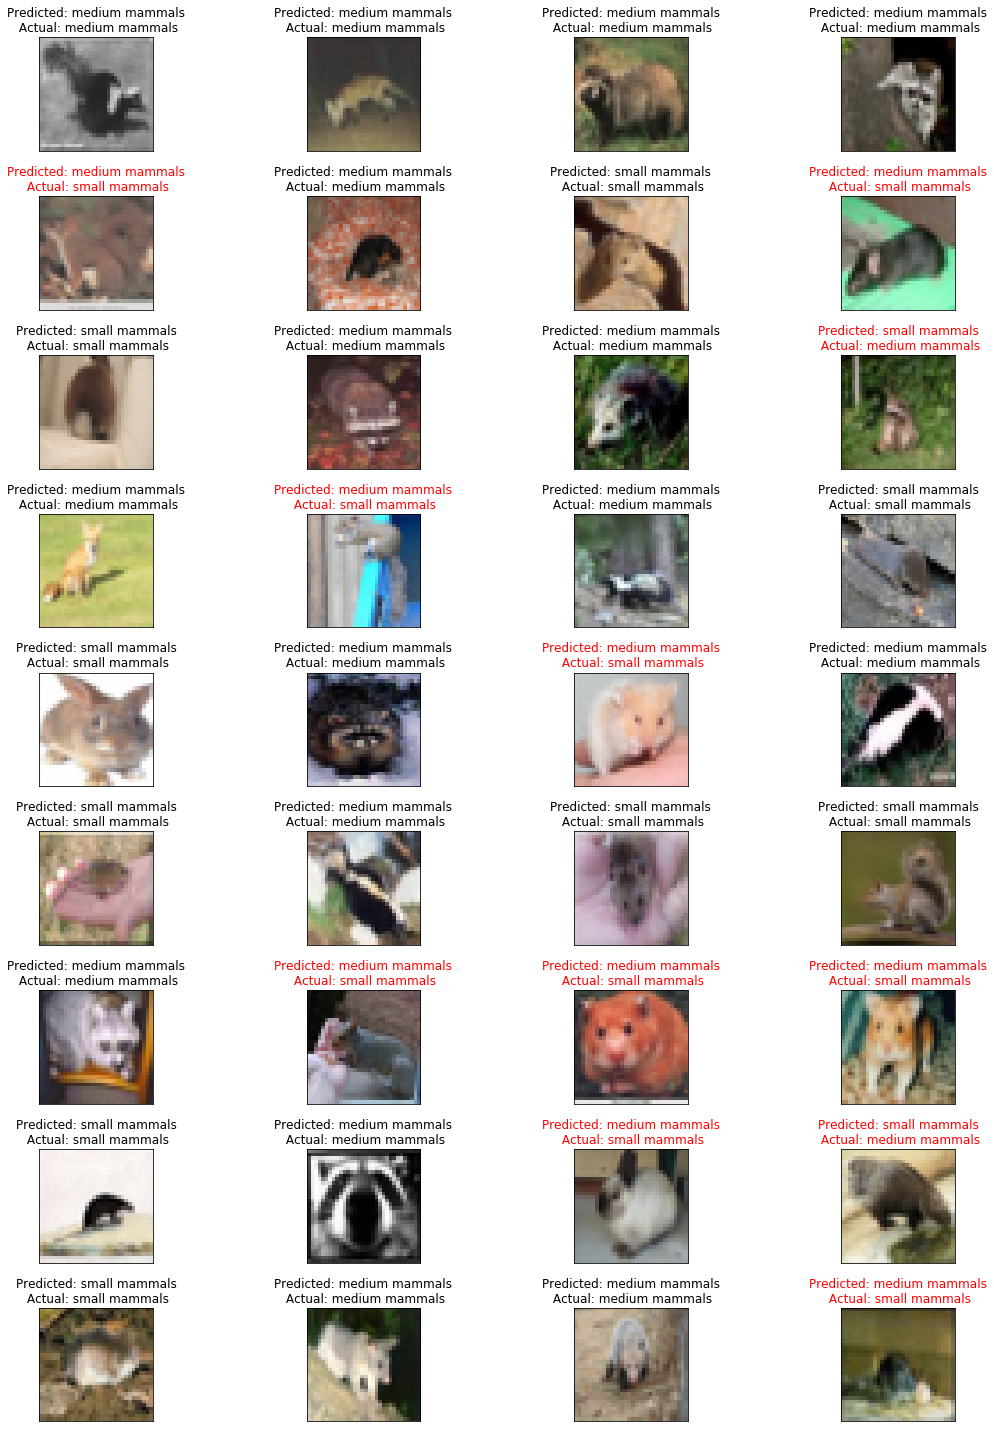

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_nb)

####**Confusion matrix and classification report for Naive Bayes Classifier**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat2 = predict_nb.select("binary_index","prediction")
print(conf_mat2.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 212, Row(binary_index=1.0, prediction=1.0): 343, Row(binary_index=0.0, prediction=0.0): 344, Row(binary_index=1.0, prediction=0.0): 244})
CPU times: user 41.2 ms, sys: 6.27 ms, total: 47.5 ms
Wall time: 3min 36s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD2 = predict_nb.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics2 = MulticlassMetrics(predictionRDD2)

cm2 = metrics2.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm2[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         344         212
real  1         244         343
CPU times: user 38.7 ms, sys: 7.64 ms, total: 46.3 ms
Wall time: 3min 36s
Parser   : 247 ms


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr2(label_in):
  precision = metrics2.precision(label=label_in)
  recall = metrics2.recall(label=label_in)
  F1_Measure = metrics2.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr2(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.59          0.62         0.60          556
       1.0         0.62          0.58         0.60          587
CPU times: user 55.9 ms, sys: 11.6 ms, total: 67.5 ms
Wall time: 7min 11s


##**Model 3** - Random Forest Classifier

In [0]:
# Import the necessary package(s)
%%time
from pyspark.ml.classification import RandomForestClassifier

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 20.3 µs


In [0]:
# Create a Random Forest classifer-based model, fit, predict and print relevant columns from the first 10 rows
%%time
rfc=RandomForestClassifier(featuresCol="features", labelCol="binary_index",numTrees=100)
rfc_model=rfc.fit(train_df)
predict_rfc=rfc_model.transform(test_df)
predict_rfc.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.40035757638691...|
|medium_mammals|         1.0|       1.0|[0.38387068492749...|
| small_mammals|         0.0|       1.0|[0.43530567957958...|
| small_mammals|         0.0|       0.0|[0.65135556347857...|
|medium_mammals|         1.0|       1.0|[0.38914469976349...|
|medium_mammals|         1.0|       1.0|[0.46753362003885...|
|medium_mammals|         1.0|       1.0|[0.37085833903610...|
|medium_mammals|         1.0|       0.0|[0.52357669190181...|
|medium_mammals|         1.0|       1.0|[0.27146339848296...|
|medium_mammals|         1.0|       1.0|[0.35838241330998...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 75.5 ms, sys: 16.3 ms, total: 91.8 ms
Wall time: 8min


In [0]:
# Print the prediction score / accuracy
%%time
accuracy3 = (eval.evaluate(predict_rfc))*100
print("Model Accuracy: %.3f%%" % accuracy3)

Model Accuracy: 66.640%
CPU times: user 13.7 ms, sys: 4.93 ms, total: 18.6 ms
Wall time: 1min 48s


CPU times: user 425 ms, sys: 4.49 ms, total: 429 ms
Wall time: 1min 48s


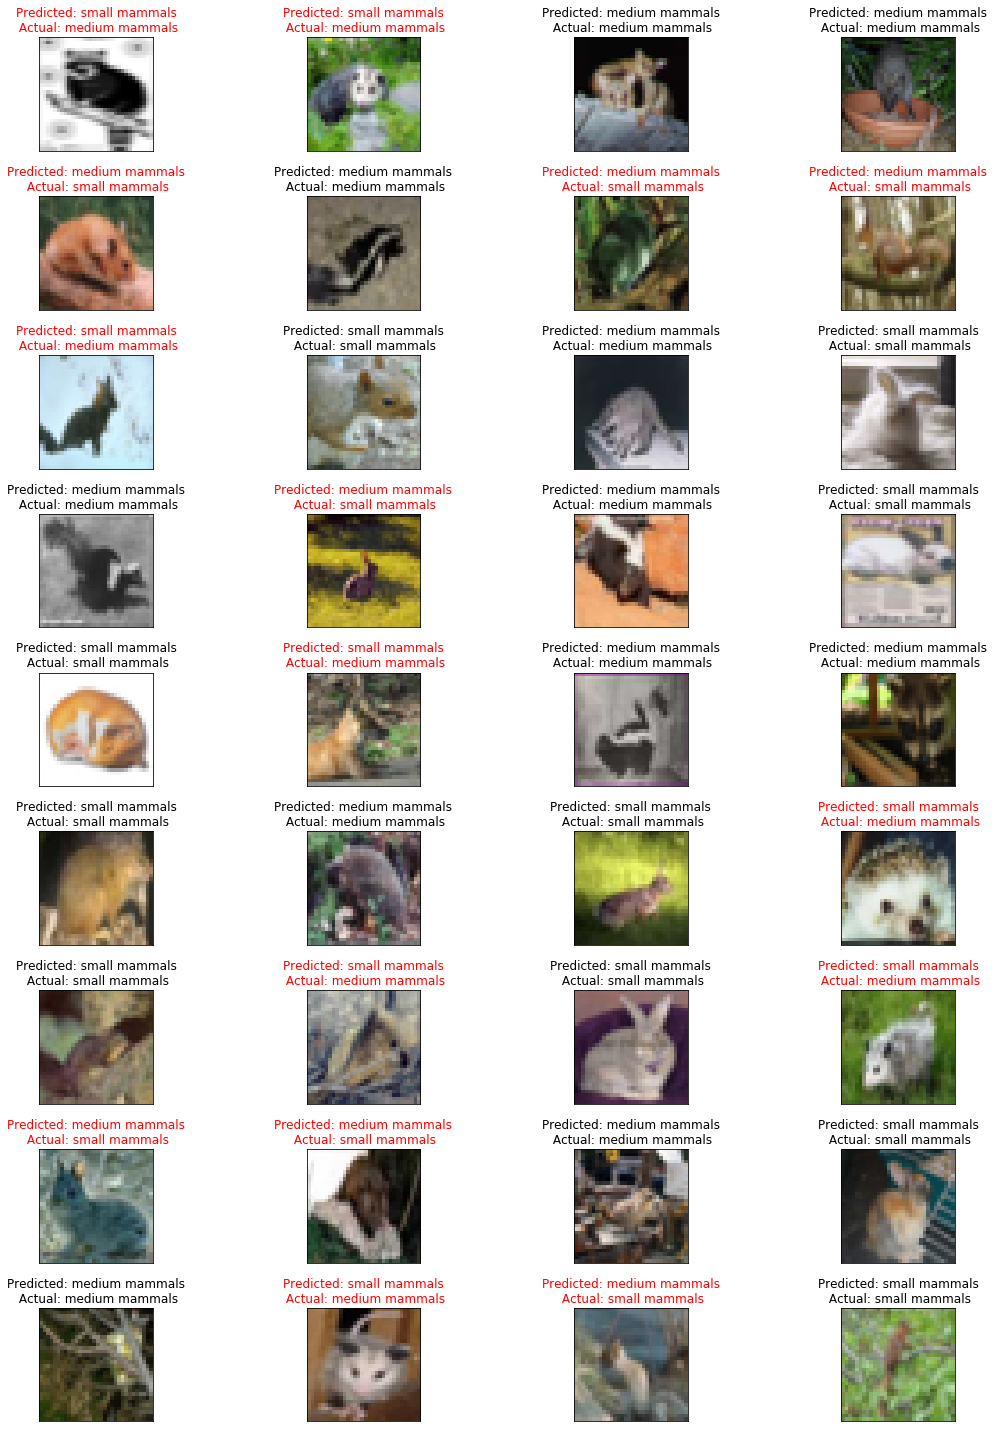

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_rfc)

####**Confusion matrix and classification report for Random Forest Classifier**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat3 = predict_rfc.select("binary_index","prediction")
print (conf_mat3.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 173, Row(binary_index=1.0, prediction=1.0): 378, Row(binary_index=0.0, prediction=0.0): 383, Row(binary_index=1.0, prediction=0.0): 209})
CPU times: user 34.6 ms, sys: 10.4 ms, total: 45 ms
Wall time: 3min 36s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD3 = predict_rfc.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics3 = MulticlassMetrics(predictionRDD3)


cm3 = metrics3.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm3[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         383         173
real  1         209         378
CPU times: user 35.2 ms, sys: 6.97 ms, total: 42.2 ms
Wall time: 3min 36s


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr3(label_in):
  precision = metrics3.precision(label=label_in)
  recall = metrics3.recall(label=label_in)
  F1_Measure = metrics3.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr3(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.65          0.69         0.67          556
       1.0         0.69          0.64         0.66          587
CPU times: user 59 ms, sys: 9.67 ms, total: 68.7 ms
Wall time: 7min 15s
